In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# all dims in meters
IN_TO_METERS = 0.0254
# https://www.dropbox.com/sh/bcnsqxhntwaoxdq/AABFhMAjY68ykwWP5YUB-46za?dl=0&preview=26624a+MIRROR+P1.pdf
# Which dim is considered X and which is Y will depend on how the mapper is mounted on the mirror.
# Verify this before using the files.
MIRRORS = {
    'P1': np.array([23.622, 19.685]) * IN_TO_METERS,
    'K1': np.array([23.622, 18.110]) * IN_TO_METERS,
    'K2': np.array([25.591, 25.591]) * IN_TO_METERS,
    'K3': np.array([29.530, 21.650]) * IN_TO_METERS,
    'F1': np.array([31.496, 18.110]) * IN_TO_METERS,
    '24in_breadboard': np.array([24.000, 24.000]) * IN_TO_METERS, # lab test surface
    '25in_breadboard': np.array([24.000, 25.000]) * IN_TO_METERS, # lab test surface
    # P2 not accessible, not mapped
}
# Which groups of IR-50s to use for each mirror:
# 0th bit = center
# 1st bit = inner ring
# 2nd bit = outer ring
# so 0 = 000 = no sources, 1 = 001 = center only, 3 = 011 = center, inner ring. etc. 
# This decision depends on how spread out the beam pattern is on each optic.
HAWKEYES = {
    'P1': 7, # all sources on
    'K1': 1, # K1 closest to focus, so only use 1 source
    'K2': 7,
    'K3': 7,
    'F1': 7,
    '24in_breadboard': 7,
    '25in_breadboard': 7,
    # P2 not accessible, not mapped
}

PROFILE_HEADER = 'flasher_cmds,pos_cmd_0s,pos_cmd_1s\n'

In [3]:
def raster(num_x, num_y, dim_x, dim_y, offset_x, offset_y):
    '''
    The scan for operational use, since it is the most time-efficient.
    '''
    X,Y = np.meshgrid(
        np.linspace(-dim_x/2, dim_x/2, num=num_x)[::-1] + offset_x,
        np.linspace(-dim_y/2, dim_y/2, num=num_y)[::-1] + offset_y
    )
    # step through points in a raster scan, starting top left
    for i in range(X.shape[0]):
        if not i % 2:
            X[i,:] = X[i,::-1]
            Y[i,:] = Y[i,::-1]
    return X,Y


def raster_skipline_SW(num_x, num_y, dim_x, dim_y, offset_x, offset_y):
    '''
    Ordered for easiest photogrammetry data processing, starts in SW.
    '''
    X,Y = np.meshgrid(
        np.linspace(-dim_x/2, dim_x/2, num=num_x)[::1] + offset_x,
        np.linspace(-dim_y/2, dim_y/2, num=num_y)[::1] + offset_y
    )
    return X,Y

def repeatability(first_x, first_y, second_x, second_y, N):
    first = (first_x, first_y)
    second = (second_x, second_y)
    return np.array([first, second] * N)

## Patterns for operational mapping

### Simple raster

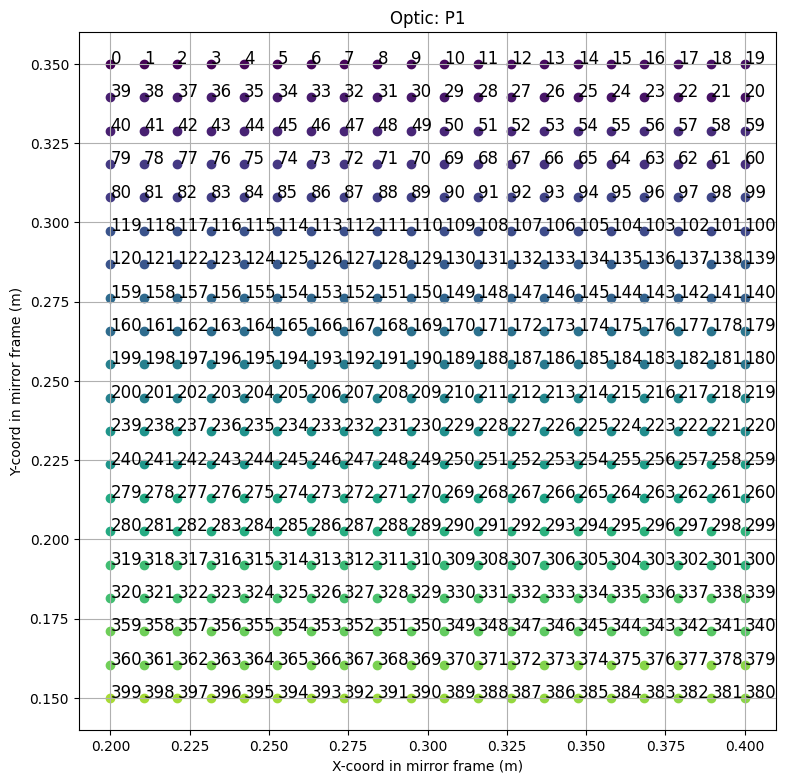

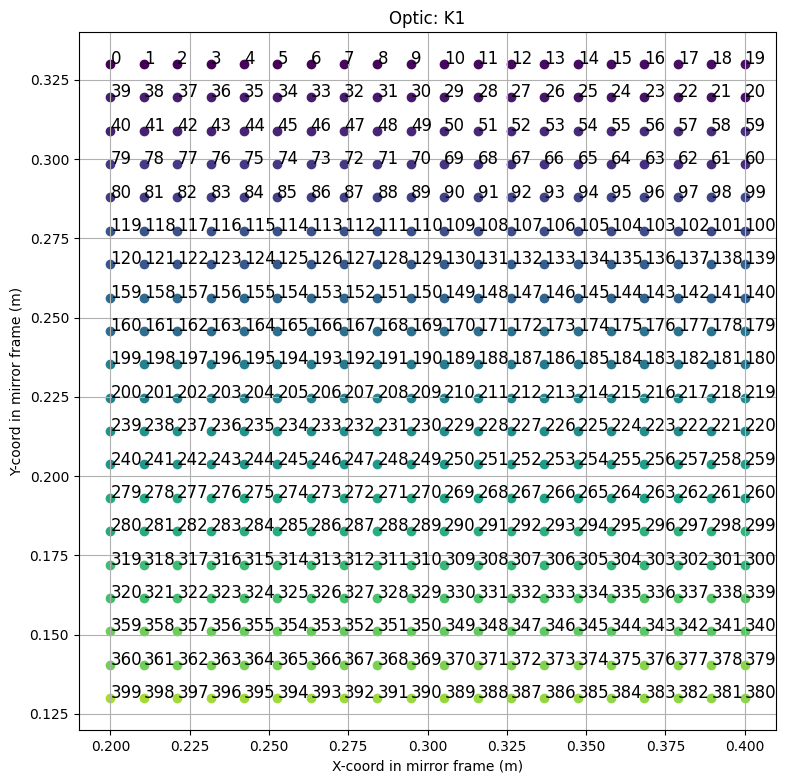

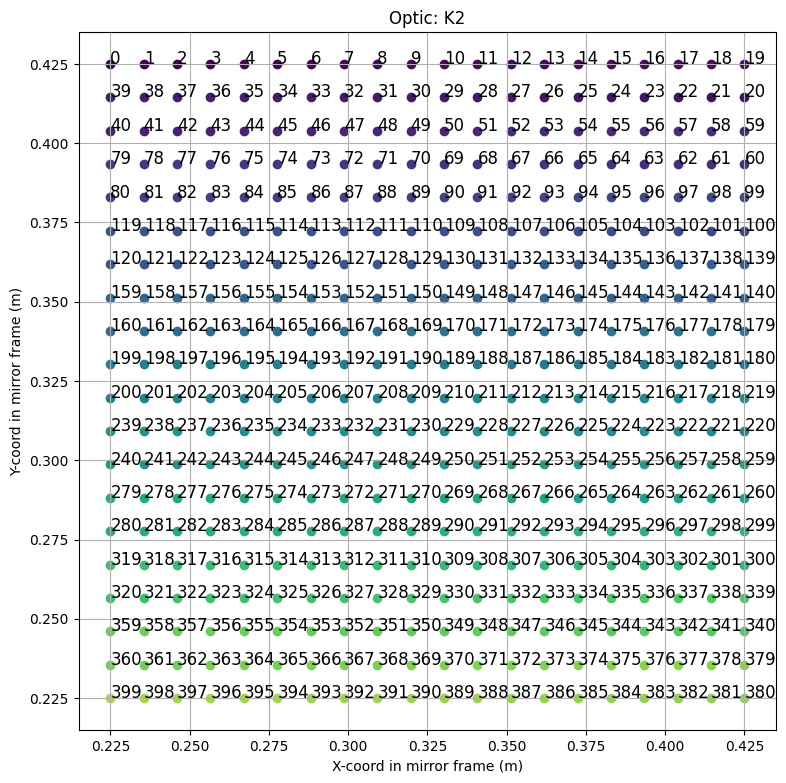

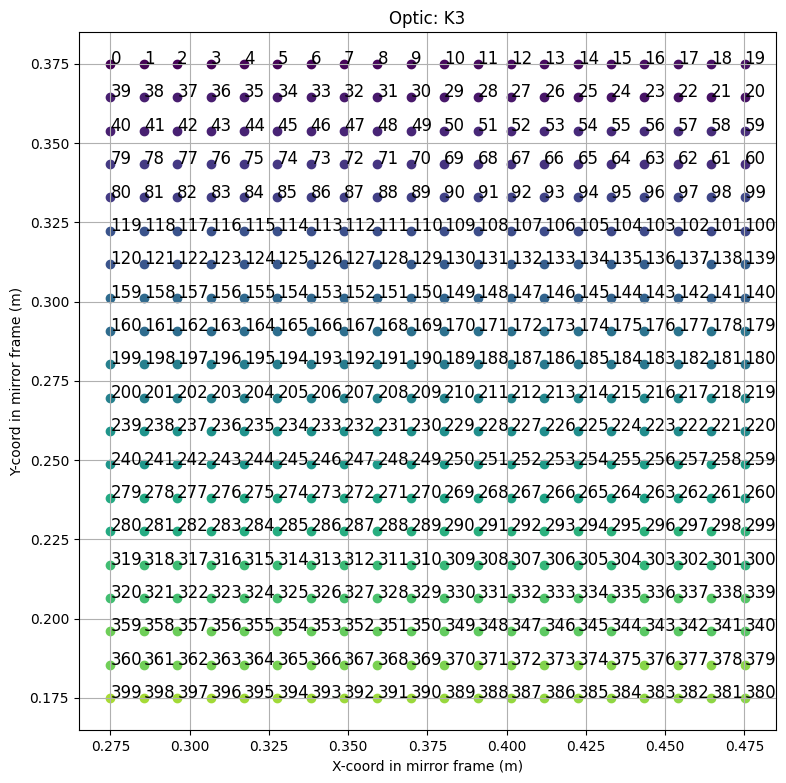

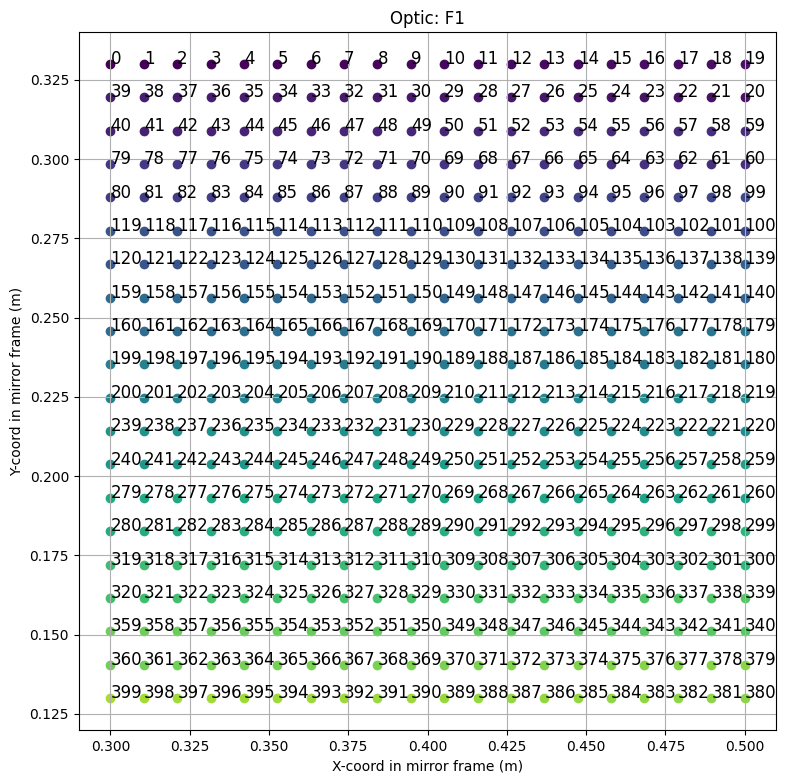

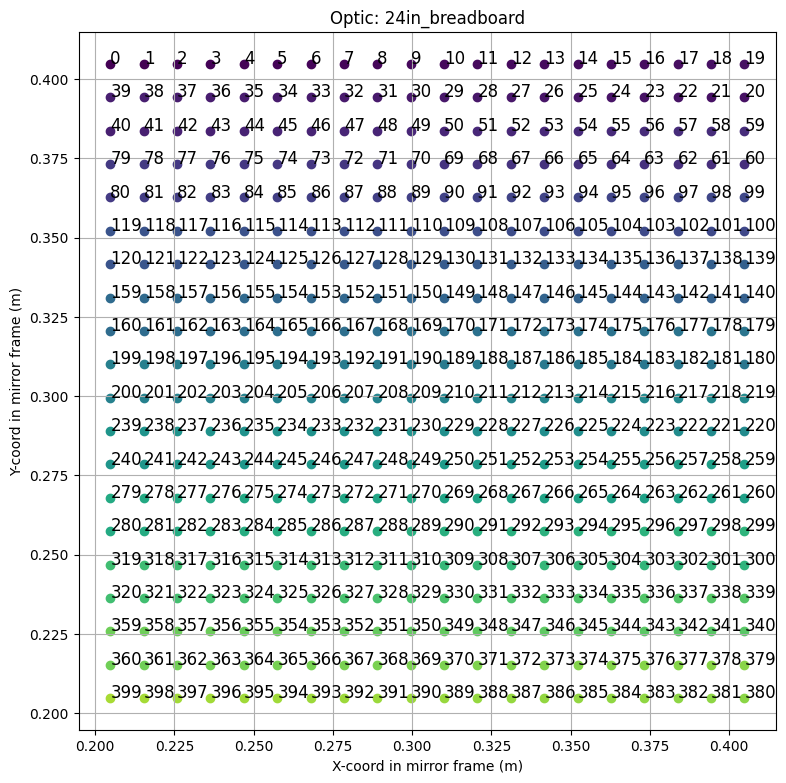

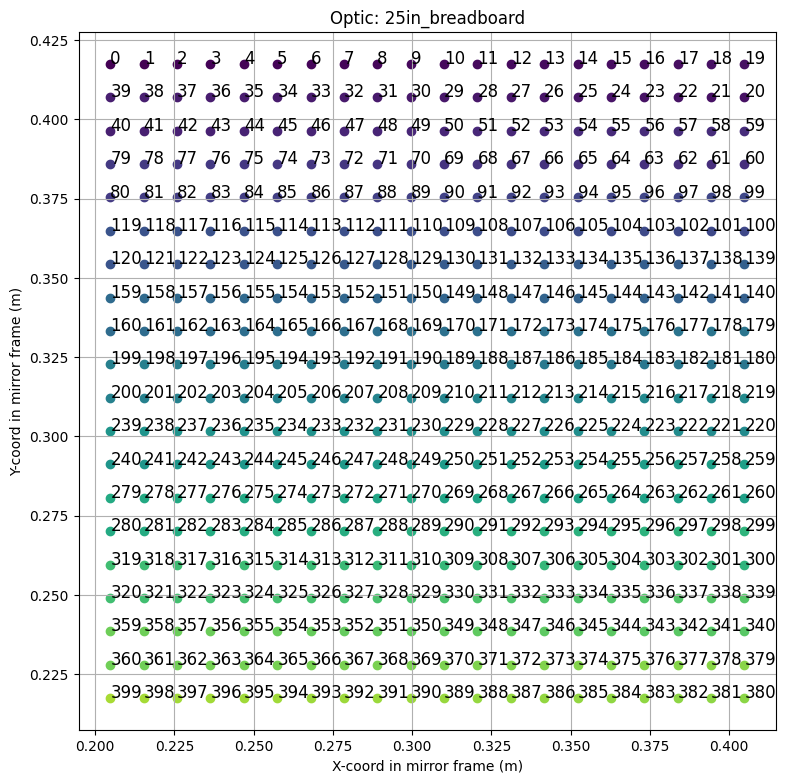

In [4]:
num_x = 20 # total num points per axis
num_y = 20
dim_x = .2 # total extent of region mapped
dim_y = .2

# Get a continuous raster pattern centered on each optic
for key in MIRRORS.keys():
    filename = key + f'_raster_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
    X,Y = raster(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
    active_hawkeyes = HAWKEYES[key]
    hawkeye_str = str(active_hawkeyes)
    
    fig, ax = plt.subplots(figsize=(9,16))
    order = 0 
    ax.set_xlabel('X-coord in mirror frame (m)')
    ax.set_ylabel('Y-coord in mirror frame (m)')
    ax.set_title(f'Optic: {key}')
    ax.set_aspect('equal')
    ax.grid(True)
    cm = plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(
            vmin=order,
            vmax=X.size * 1.15
        ),
        cmap='viridis'
    )
    cs = cm.to_rgba(range(X.size))
    
    with open(filename, 'w') as f:
        f.write(PROFILE_HEADER)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
                ax.scatter(X[i][j], Y[i][j], color=cs[order])
                order += 1
                line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
                f.write(line) 

### Raster with tie-points

Same as a raster, but before moving to next row, visits the center of the optic to allow detector drift fitting.

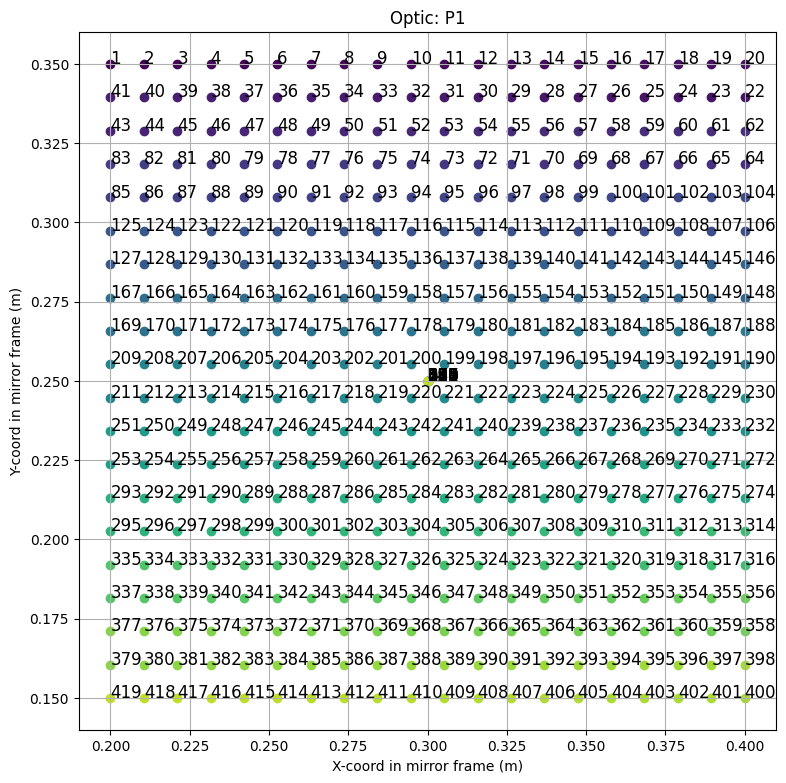

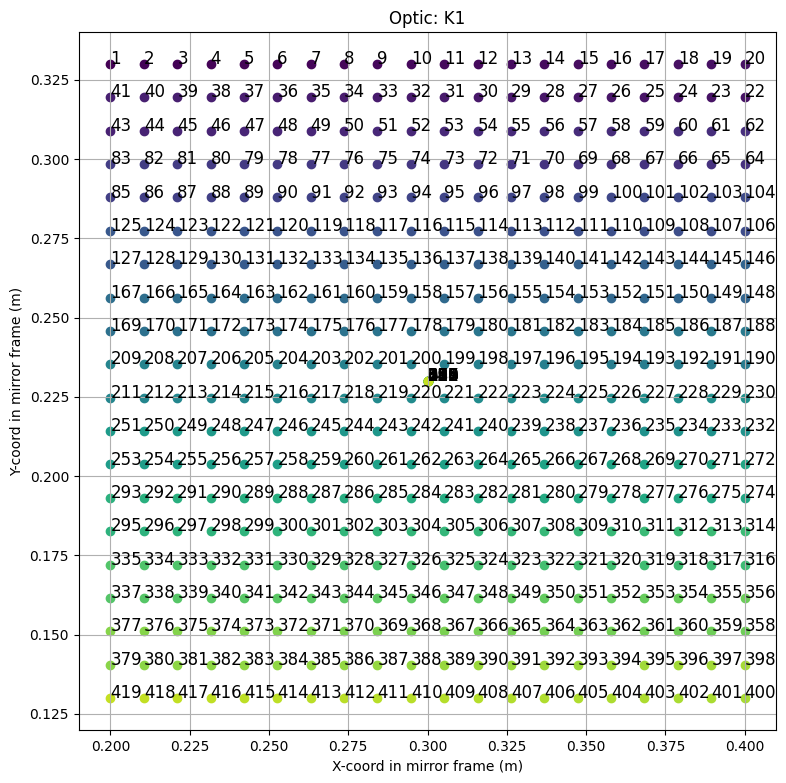

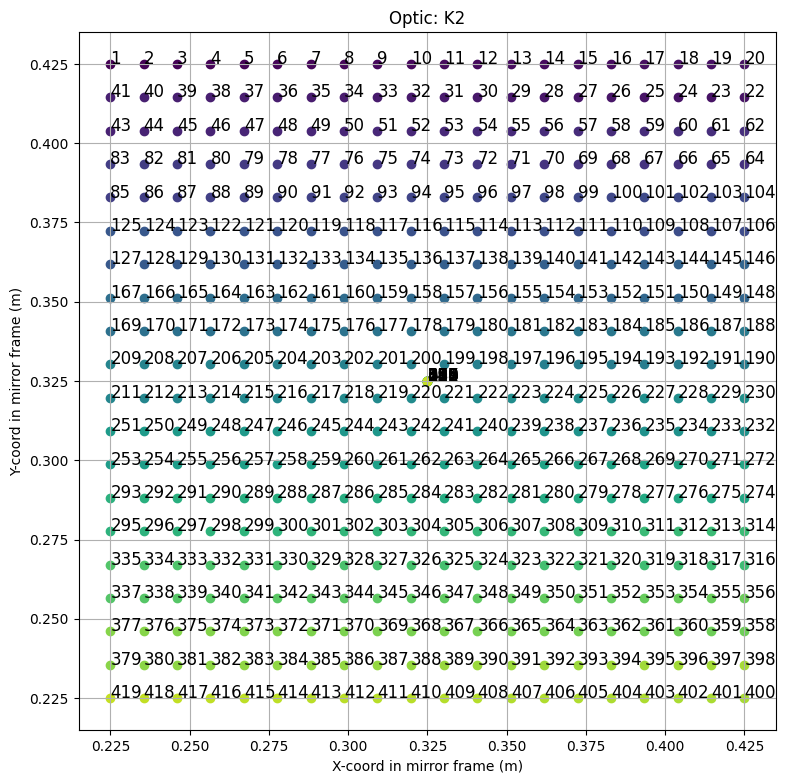

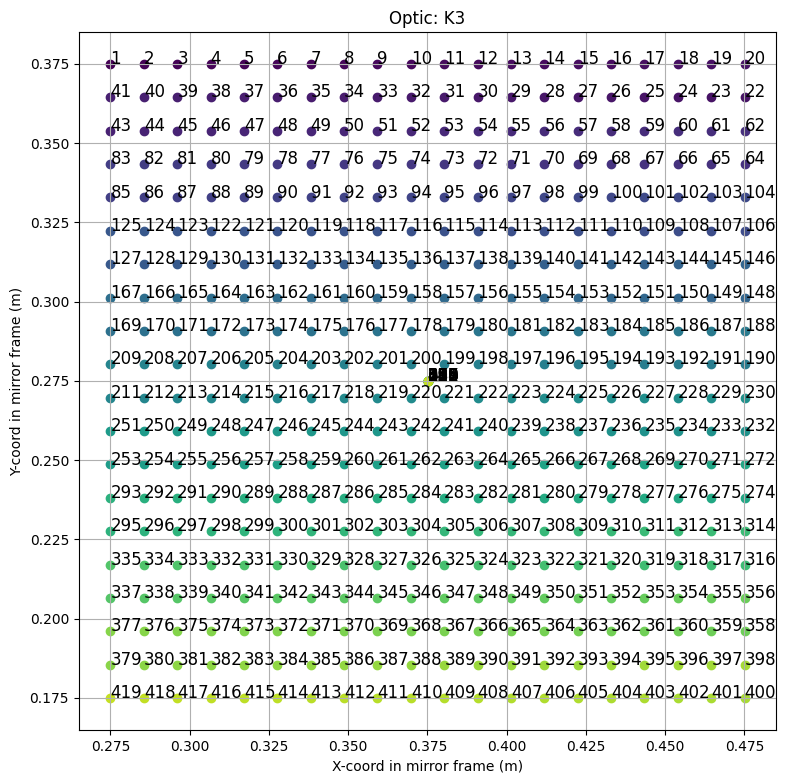

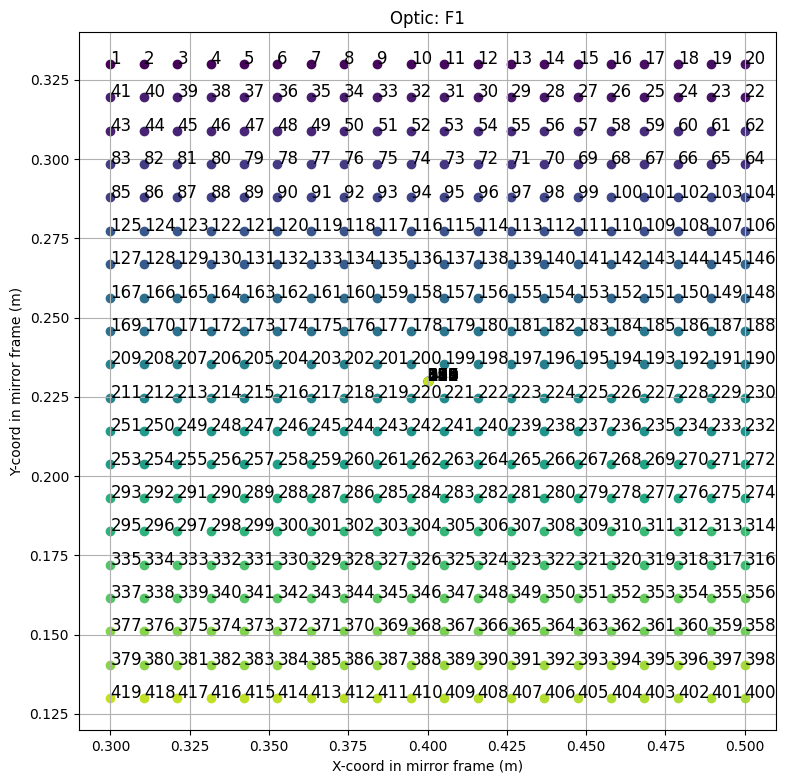

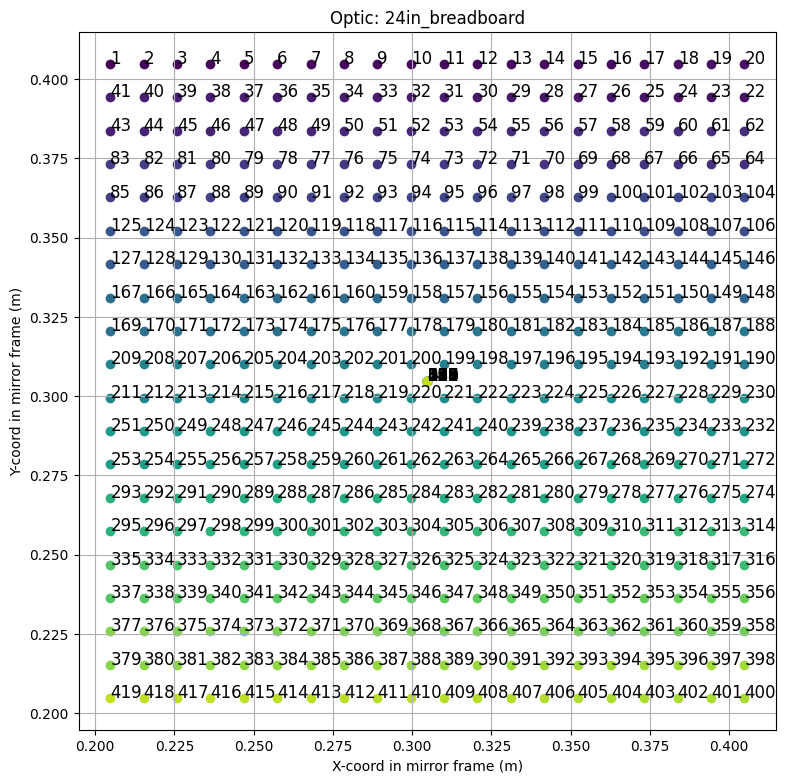

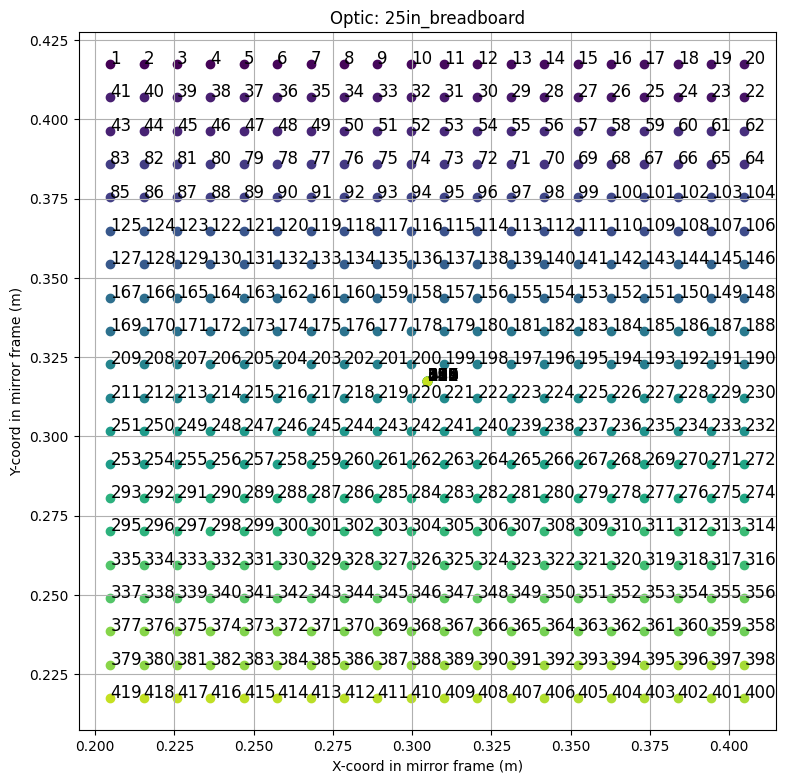

In [5]:
num_x = 20 # total num points per axis
num_y = 20
dim_x = .2 # total extent of region mapped
dim_y = .2

# Get a continuous raster pattern centered on each optic
for key in MIRRORS.keys():
    filename = key + f'_raster_tie_point_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
    X,Y = raster(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
    active_hawkeyes = HAWKEYES[key]
    hawkeye_str = str(active_hawkeyes)
    
    fig, ax = plt.subplots(figsize=(9,16))
    order = 0 
    ax.set_xlabel('X-coord in mirror frame (m)')
    ax.set_ylabel('Y-coord in mirror frame (m)')
    ax.set_title(f'Optic: {key}')
    ax.set_aspect('equal')
    ax.grid(True)
    cm = plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(
            vmin=order,
            vmax=X.size * 1.15
        ),
        cmap='viridis'
    )
    cs = cm.to_rgba(range(1 + X.size + X.shape[0]))

    with open(filename, 'w') as f:
        f.write(PROFILE_HEADER)
        # visit center.
        ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
        ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
        order += 1
        line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
        f.write(line)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
                ax.scatter(X[i][j], Y[i][j], color=cs[order])
                order += 1
                line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
                f.write(line)
            # visit center.
            ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
            ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
            order += 1
            line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
            f.write(line)


### Same as above, but only 4 points

In [6]:
# num_x = 2 # total num points per axis
# num_y = 2
# dim_x = .2 # total extent of region mapped
# dim_y = .2

# # Get a continuous raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_tie_point_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(1 + X.size + X.shape[0]))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         # visit center.
#         ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
#         ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
#         order += 1
#         line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
#         f.write(line)

#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line)
#             # visit center.
#             ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
#             ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
#             order += 1
#             line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
#             f.write(line)

### Same as above, but more tie points.

In [7]:
# num_x = 10 # total num points per axis
# num_y = 10
# dim_x = .4 # total extent of region mapped
# dim_y = .4

# # Get a continuous raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_many_tie_point_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 2
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(2*(1 + X.size + X.shape[0])))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         # visit center.
#         ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
#         ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
#         order += 1
#         line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
#         f.write(line)

#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line)
#                 # visit center.
#                 ax.annotate(f'{order}', (MIRRORS[key][0]/2, MIRRORS[key][1]/2), fontsize=12)
#                 ax.scatter(MIRRORS[key][0]/2, MIRRORS[key][1]/2, color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(MIRRORS[key][0]/2), str(MIRRORS[key][1]/2)]) + '\n'
#                 f.write(line)


## Patterns for photogrammetry

### Ultra Fine

In [8]:
# num_x = 24 # total num points per axis
# num_y = 24
# dim_x = .3 # total extent of region mapped
# dim_y = .3

# # Get a coarser, skipline raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(X.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line)


### Super Fine

In [9]:
# num_x = 18 # total num points per axis
# num_y = 18
# dim_x = .3 # total extent of region mapped
# dim_y = .3

# # Get a coarser, skipline raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(X.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line)


### Fine

In [10]:
# num_x = 10 # total num points per axis
# num_y = 10
# dim_x = .3 # total extent of region mapped
# dim_y = .3

# # Get a coarser, skipline raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(X.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line)

### Coarse

In [11]:
# num_x = 4 # total num points per axis
# num_y = 4
# dim_x = .3 # total extent of region mapped
# dim_y = .3

# # Get a coarser, skipline raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(X.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line) 

### Small

In [12]:
# num_x = 10# total num points per axis
# num_y = 10
# dim_x = .03 # total extent of region mapped
# dim_y = .03

# # Get a coarser, skipline raster pattern centered on each optic
# for key in MIRRORS.keys():
#     filename = key + f'_raster_skipline_{num_x}x{num_y}_{dim_x:.2f}mx{dim_y:.2f}m' + '.csv'
#     X,Y = raster_skipline_SW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=X.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(X.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for i in range(X.shape[0]):
#             for j in range(X.shape[1]):
#                 ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
#                 ax.scatter(X[i][j], Y[i][j], color=cs[order])
#                 order += 1
#                 line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
#                 f.write(line) 

### Repeatability

In [13]:
# # Visit two points repeatedly.
# N = 25
# x0 = 0.15
# y0 = 0.15
# x1 = MIRRORS[key][0]/2
# y1 = MIRRORS[key][1]/2
# for key in [item for item in MIRRORS.keys() if 'breadboard' in item]:
#     filename = key + f'_repeatability_N_{N}' + '.csv'
#     pts = repeatability(x0, y0, x1, y1, N)
#     active_hawkeyes = HAWKEYES[key]
#     hawkeye_str = str(active_hawkeyes)
    
#     fig, ax = plt.subplots(figsize=(9,16))
#     order = 0 
#     ax.set_xlabel('X-coord in mirror frame (m)')
#     ax.set_ylabel('Y-coord in mirror frame (m)')
#     ax.set_title(f'Optic: {key}')
#     ax.set_aspect('equal')
#     ax.grid(True)
#     cm = plt.cm.ScalarMappable(
#         norm=matplotlib.colors.Normalize(
#             vmin=order,
#             vmax=pts.size * 1.15
#         ),
#         cmap='viridis'
#     )
#     cs = cm.to_rgba(range(pts.size))

#     with open(filename, 'w') as f:
#         f.write(PROFILE_HEADER)
#         for pt in pts:
#             ax.annotate(f'{order}', (pt[0], pt[1]), fontsize=12)
#             ax.scatter(pt[0], pt[1], color=cs[order])
#             order += 1
#             line = ','.join([hawkeye_str, str(pt[0]), str(pt[1])]) + '\n'
#             f.write(line) 